# Case 3 - Medical text categorization

Tom Thiel<br>
Metropolias UAS<br>
12.3.2018

## 1. Objectives

Objective of this assignment is build a document classifier for 20 000 cardiovascular disease abstracts. 

To build a Natural Language Classifier in Keras you need to first preprocess the data by tokenizing the words. For this data set we have to create a vocabulary. 

## 2. Load data and find the labels

In [51]:
#Download the training data and the labels

import os

case3_dir = '../ohsumed-first-20000-docs/'
train_dir = os.path.join(case3_dir, 'training')

labels = []
texts = []


# to see how many abstracts there are in each directory
label_list = [label for label in os.listdir(train_dir)]

for label_type in label_list:
    dir_name = os.path.join(train_dir, label_type)
    print(label_type, len(os.listdir(dir_name)))
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        labels.append(label_list.index(label_type))

C01 423
C02 158
C03 65
C04 1163
C05 283
C06 588
C07 100
C08 473
C09 125
C10 621
C11 162
C12 491
C13 281
C14 1249
C15 215
C16 200
C17 295
C18 388
C19 191
C20 525
C21 546
C22 92
C23 1799


## 3. Shape and preprocess data 


In [52]:
#Preprocess integer labels into one-hot tensor labels

from keras.utils.np_utils import to_categorical
import numpy as np

labels = np.asarray(labels)
labels = to_categorical(labels)
print('Shape of labels tensor:', labels.shape)

Shape of labels tensor: (10433, 23)



Setting the vocabulary of the documents to 20 000 will cut off text any longer and for shorter abstracts the zeros will be filled to rest of the vector. 

In [58]:
#Preprocess word data into integer tensors
#Each sample is zero-padded to length "maxlen"
#Only "max_words" most frequent words are taken into account

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 300 # common length of all the samples
max_words = 20000 # number of different word indices

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

# add padding, so that every letter gets vectorized
data = pad_sequences(sequences, maxlen = maxlen)

print('Shape of data tensor:', data.shape)

Found 30857 unique tokens
Shape of data tensor: (10433, 300)


Training data must be suffled for validation split. Keras validation split picks out samples from the bottom of the data and in this case they would all be from category nro 23 which has 1799 samples. 

https://github.com/keras-team/keras/issues/597

Let's test how the labels are suffled by printing abstract nro 7


In [54]:
samples = np.arange(data.shape[0])
print((texts[indices[6]]))

Management of penile gunshot wounds.
 The management of 10 cases of penile gunshot wounds treated at Henry Ford Hospital from 1982 to 1986 is reviewed.
 All patients were assaulted by low velocity weapons (handguns).
 Eight patients had associated injuries, predominantly to the genital region (thigh, pubis, and scrotum).
 There were 5 urethral injuries; 4 were treated with primary repair, the remaining patient underwent delayed repair, complicated by severe urethral strictures requiring reoperation.
 Blood at the urethral meatus was suggestive of urethral injury but microscopic hematuria was not.
 Five penile injuries did not involve the urethra and were treated by debridement and primary wound closure with no immediate or delayed complications.
 In dealing with these injuries we recommend a high index of suspicion for urethral and regional organ injury and primary urethral closure if at all possible.



In [55]:
#Shuffle the training data 

np.random.shuffle(samples)
data = data[samples]
labels = labels[samples]

In [56]:
#print abstract nro 7 again and see if it's the same
print(texts[samples[6]])

Death at cardiac catheterization: coronary artery embolization of calcium debris from Ionescu-Shiley bioprosthesis.
 The case described is a death due to embolization of calcium debris from a bioprosthesis, dislodged at cardiac catheterization.
 As more bioprosthetic valves are implanted, and more of them fail long-term with calcification, such complications of the invasive study of these valves may be expected.



The suffling was successful.

## 5. Modeling

Time to use embedding to get rid of one-hot vectors and use more sophisticated way for presenting the words in matrixes. There will be only one representation for each word during and after training.

Texts to matrix -> default way in keras. It loses the order of words so it is not suitable for machine translation. 

Neural network based models like vector inputs. We, therefore, need to convert the integers into vectors. 
Embedding turns positive integers (indexes) into dense vectors of fixed size. eg. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]<br> <br> 
Embedding layer can only be used as the first layer in a model. It can also be used alone to learn a word embedding that can be saved and used in another model later.

Embedding layer must specify 3 arguments:
<li>input_dim</li>
<li>output_dim</li>
<li>input_length</li>

Using LSTM (or any other type of RNN with time sequence) you don't need flattening layers before fully connected dense layer as the output shape is 100x1.

The key to LSTMs is the cell state, a line running through the states (sequences). It can store values from state to state.

In [59]:
#Build and compile the network model

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

model = Sequential()
#create 300x32 matrix
model.add(Embedding(max_words, 32, input_shape=(maxlen,))) 
model.add(LSTM(100)) #matrix size 100x1
model.add(Dense(23, activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 32)           640000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 23)                2323      
Total params: 695,523
Trainable params: 695,523
Non-trainable params: 0
_________________________________________________________________


## 5. Training



In [67]:
# Fit the model to training data

import time

t1 = time.time()
# takes 5 % and uses it as validation data
history = model.fit(data, labels,
                   epochs = 12,
                   batch_size = 25,
                   validation_split = 0.05) 
t2 = time.time()
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))


Train on 9911 samples, validate on 522 samples
Epoch 1/12
9911/9911 [==============================] - 101s 10ms/step - loss: 2.4738 - acc: 0.2621 - val_loss: 2.9479 - val_acc: 0.1437
Epoch 2/12
9911/9911 [==============================] - 103s 10ms/step - loss: 2.3318 - acc: 0.3011 - val_loss: 3.1210 - val_acc: 0.1111
Epoch 3/12
9911/9911 [==============================] - 104s 11ms/step - loss: 2.1942 - acc: 0.3431 - val_loss: 3.2645 - val_acc: 0.1149
Epoch 4/12
9911/9911 [==============================] - 106s 11ms/step - loss: 2.0674 - acc: 0.3753 - val_loss: 3.2694 - val_acc: 0.1130
Epoch 5/12
9911/9911 [==============================] - 104s 11ms/step - loss: 1.9571 - acc: 0.4102 - val_loss: 3.5039 - val_acc: 0.1092
Epoch 6/12
9911/9911 [==============================] - 104s 11ms/step - loss: 1.8411 - acc: 0.4407 - val_loss: 3.5984 - val_acc: 0.1130
Epoch 7/12
9911/9911 [==============================] - 98s 10ms/step - loss: 1.7437 - acc: 0.4546 - val_loss: 3.7881 - val_acc: 0.

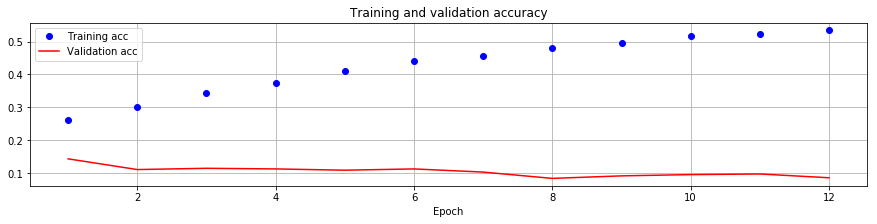

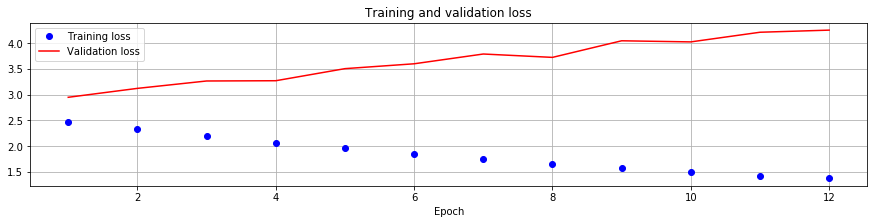

In [68]:
# Plot the results for model 1
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.legend()


plt.figure(figsize=(15, 3))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.xlabel('Epoch')
plt.legend()

plt.show()

Acc > 0.5<br>
Val_acc < 0.1 

The model is definately <b>overfitting</b>. Let's try with other hyperparameters:
<br>
<li> batch_size 20 -> 10</li>
<li>10 epocs is enough</li>
<li>up the validations split 0.05 -> 0.2</li>

In [69]:
t1 = time.time()
# takes 20% and uses it as validation data
history = model.fit(data, labels,
                   epochs = 10,
                   batch_size = 10,
                   validation_split = 0.2) 
t2 = time.time()
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))

Train on 8346 samples, validate on 2087 samples
Epoch 1/10
8346/8346 [==============================] - 175s 21ms/step - loss: 1.3573 - acc: 0.5440 - val_loss: 2.3499 - val_acc: 0.3421
Epoch 2/10
8346/8346 [==============================] - 172s 21ms/step - loss: 1.2870 - acc: 0.5752 - val_loss: 2.5550 - val_acc: 0.3009
Epoch 3/10
8346/8346 [==============================] - 172s 21ms/step - loss: 1.2215 - acc: 0.5851 - val_loss: 2.7072 - val_acc: 0.2645
Epoch 4/10
8346/8346 [==============================] - 180s 22ms/step - loss: 1.1630 - acc: 0.6034 - val_loss: 2.8892 - val_acc: 0.2496
Epoch 5/10
8346/8346 [==============================] - 184s 22ms/step - loss: 1.1201 - acc: 0.6099 - val_loss: 3.0673 - val_acc: 0.2286
Epoch 6/10
8346/8346 [==============================] - 181s 22ms/step - loss: 1.0734 - acc: 0.6250 - val_loss: 3.2832 - val_acc: 0.2262
Epoch 7/10
8346/8346 [==============================] - 183s 22ms/step - loss: 1.0491 - acc: 0.6208 - val_loss: 3.3330 - val_acc: 

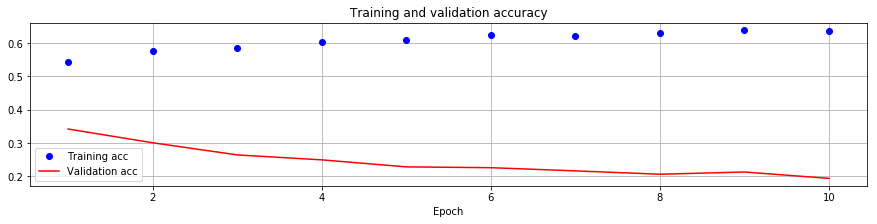

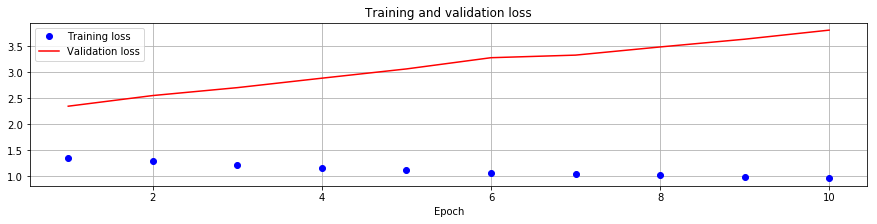

In [71]:
# Plot the results for model 2
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.legend()


plt.figure(figsize=(15, 3))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.xlabel('Epoch')
plt.legend()

plt.show()

With lower batch size the training took 40 % seconds longer (1700 vs 1200sec).

This time the validation accuracy stayed around 0.2. The model is still overfit, but I think is because of the size of training data and lack of stop word removal in preprocessing. 

## 6. Evaluating with test data

In [72]:
#Download and preprocess test data

test_dir = os.path.join(case3_dir, 'test')

test_labels = []
test_texts = []

for label_type in label_list:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        test_texts.append(f.read())
        f.close()
        test_labels.append(label_list.index(label_type))

test_sequences = tokenizer.texts_to_sequences(test_texts)
x_test = pad_sequences(test_sequences, maxlen=maxlen)
test_labels = np.asarray(test_labels)
y_test = to_categorical(test_labels)

In [73]:
# Evaluate model with test data
# http://scikit-learn.org/stable/modules/model_evaluation.html

model.evaluate(x_test, y_test)

12733/12733 [==============================] - 31s 2ms/step


[4.2187468584284318, 0.081834602997737982]

## 7. Results

Model 2 achieved 8 % accuracy with test set. That is almost as bad as randomly guessing (1/23 = 0.0434) the classes. 

## 8. Testing the Pre-Trained GloVe Embedding
 
As a final attempt I downloaded the glove6b pretrained model. I wanted to see if it could be used on this particular problem. 

At first I ran into decoding issue, which could be fixed with forcing the char-encoding to utf8.

In [95]:
from numpy import asarray
from numpy import zeros
from keras.layers import Flatten

t1 = time.time()

vocab_size = len(tokenizer.word_index) + 1

# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
    
# compile the model with adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# summarize the model
print(model.summary())

t2 = time.time()
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))


Loaded 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 4, 100)            3085800   
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 401       
Total params: 3,086,201
Trainable params: 401
Non-trainable params: 3,085,800
_________________________________________________________________
None
Elapsed time: 19.71 seconds


Got the model loaded after few tweaks. But then got stuck trying to fit the data in for training. 

In [103]:
# fit the model
model.fit(data, labels, 
          epochs=10, 
          batch_size = 10)

# evaluate the model
loss, accuracy = model.evaluate(data, labels, verbose=1)
print('Accuracy: %f' % (accuracy*100))

ValueError: Error when checking input: expected embedding_7_input to have shape (None, 4) but got array with shape (10433, 300)